<a href="https://colab.research.google.com/github/Soumi7/TFNotebooks/blob/master/video_classsification_working_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contents :

- Downloading Dataset
- Trimming Dataset videos
- Dataset Preprocessing
- Model creation
- Model training
- Testing on test data
- Save and download model
- Inference code for testing on single Video


# Downloading Dataset


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import random
import os
import ssl
import cv2
import numpy as np
import imageio
from IPython import display
from urllib import request
import re
import tempfile

In [ ]:
UCF_ROOT = "https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/"
_VIDEO_LIST = None
Videos ={}
_CACHE_DIR = tempfile.mkdtemp()
unverified_context = ssl._create_unverified_context()
def list_ucf_videos():
  global _VIDEO_LIST
  if not _VIDEO_LIST:
    index = request.urlopen(UCF_ROOT, context=unverified_context).read().decode("utf-8")
    v = ['HandstandPushups','HandstandWalking','PullUps','Punch','PushUps']
    for i in v:
      s = "(v_"+str(i)+"[\w_]+\.avi)"
      videos = re.findall(s, index)
      Videos[i]=sorted(set(videos))
  return Videos

In [ ]:
V={}
V = list_ucf_videos()
for key,value in V.items():
  print(key,value)

HandstandPushups ['v_HandstandPushups_g01_c01.avi', 'v_HandstandPushups_g01_c02.avi', 'v_HandstandPushups_g01_c03.avi', 'v_HandstandPushups_g01_c04.avi', 'v_HandstandPushups_g02_c01.avi', 'v_HandstandPushups_g02_c02.avi', 'v_HandstandPushups_g02_c03.avi', 'v_HandstandPushups_g02_c04.avi', 'v_HandstandPushups_g03_c01.avi', 'v_HandstandPushups_g03_c02.avi', 'v_HandstandPushups_g03_c03.avi', 'v_HandstandPushups_g03_c04.avi', 'v_HandstandPushups_g04_c01.avi', 'v_HandstandPushups_g04_c02.avi', 'v_HandstandPushups_g04_c03.avi', 'v_HandstandPushups_g04_c04.avi', 'v_HandstandPushups_g05_c01.avi', 'v_HandstandPushups_g05_c02.avi', 'v_HandstandPushups_g05_c03.avi', 'v_HandstandPushups_g05_c04.avi', 'v_HandstandPushups_g06_c01.avi', 'v_HandstandPushups_g06_c02.avi', 'v_HandstandPushups_g06_c03.avi', 'v_HandstandPushups_g06_c04.avi', 'v_HandstandPushups_g07_c01.avi', 'v_HandstandPushups_g07_c02.avi', 'v_HandstandPushups_g07_c03.avi', 'v_HandstandPushups_g07_c04.avi', 'v_HandstandPushups_g08_c01.av

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
unverified_context = ssl._create_unverified_context()
def fetch_ucf_video(video):
  cache_path = os.path.join(_CACHE_DIR, video)
  if not os.path.exists(cache_path):
    urlpath = request.urljoin(UCF_ROOT, video)
    print("Fetching %s => %s" % (urlpath, cache_path))
    data = request.urlopen(urlpath, context=unverified_context).read()
    open(cache_path, "wb").write(data)
  return cache_path

In [ ]:
UCF_ROOT = "https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/"

V={}
V = list_ucf_videos()
for i,value in V.items():
  _VIDEO_LIST = V[i]
  _CACHE_DIR = "/content/drive/MyDrive/video_classification_exercise/dataset/" + str(i) + "/"
  for j in _VIDEO_LIST:  
    video_path = fetch_ucf_video(j)

Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_HandstandPushups_g01_c01.avi => /content/drive/MyDrive/video_classification_exercise/dataset/HandstandPushups/v_HandstandPushups_g01_c01.avi
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_HandstandPushups_g01_c02.avi => /content/drive/MyDrive/video_classification_exercise/dataset/HandstandPushups/v_HandstandPushups_g01_c02.avi
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_HandstandPushups_g01_c03.avi => /content/drive/MyDrive/video_classification_exercise/dataset/HandstandPushups/v_HandstandPushups_g01_c03.avi
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_HandstandPushups_g01_c04.avi => /content/drive/MyDrive/video_classification_exercise/dataset/HandstandPushups/v_HandstandPushups_g01_c04.avi
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_HandstandPushups_g02_c01.avi => /content/drive/MyDrive/video_classification_exercise/dataset/HandstandPushups/v_HandstandPushups_g02_c01.avi


# imports


In [ ]:
import numpy as np
import pandas as pd
from keras import backend as K
import sys
import csv
import os

import cv2
import math
import random
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)
data_root = '/content/drive/My Drive/video_classification_exercise/dataset/'
folder_root = '/content/drive/My Drive/video_classification_exercise/'

In [ ]:
import gc
gc.collect()

1238

# CSV creation

Video path -> Classname

In [ ]:


classes = ['HandstandPushups','HandstandWalking','PullUps','Punch','PushUps']

with open(folder_root+'dataset.csv', 'w', newline='') as file:
  writer = csv.writer(file)
  for c in classes:
    path = os.path.join(data_root, c+"/")
    for i in os.listdir(path):
      writer.writerow([classes.index(c), os.path.join(path, i)])

## shuffling csv data


In [ ]:
# shuffle the data in csv
df = pd.read_csv(folder_root+'/'+'dataset.csv')
ds = df.sample(frac=1)
ds.to_csv(folder_root+'dataset.csv', index=False)

In [ ]:
# split the data

import numpy as np
df = pd.read_csv(folder_root+'dataset.csv', header=None)
df.columns = ["class", "path"]
df = df.astype({"class": str})
train, test = np.split(df.sample(frac=1, random_state=42), [int(.8*len(df))])

In [ ]:
train.to_pickle(data_root+'train.pkl')
test.to_pickle(data_root+'test.pkl')

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20

MAX_SEQ_LENGTH = 100
NUM_FEATURES = 2048

In [ ]:
train_df = train
test_df = test

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 480
Total videos for testing: 121


class                                               path
190     3  /content/drive/My Drive/video_classification_e...
85      3  /content/drive/My Drive/video_classification_e...
420     1  /content/drive/My Drive/video_classification_e...
111     2  /content/drive/My Drive/video_classification_e...
502     4  /content/drive/My Drive/video_classification_e...
169     2  /content/drive/My Drive/video_classification_e...
535     3  /content/drive/My Drive/video_classification_e...
181     0  /content/drive/My Drive/video_classification_e...
153     3  /content/drive/My Drive/video_classification_e...
481     0  /content/drive/My Drive/video_classification_e...

# Trim Dataset Script

This is to trim the video according to the manually taken timestamps :

In [ ]:
!pip install moviepy

In [ ]:
sample = open(data_root+'timestamps.csv', 'r') 

In [ ]:
data_root = '/content/drive/My Drive/video_classification_exercise/dataset'

In [ ]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip

def get_sec(time_str):
    """Get Seconds from time."""
    m, s = time_str.split(':')
    return int(m) * 60 + int(s)

for i in os.listdir(data_root):
    os.makedirs(data_root+i+'/trim/', exist_ok=True)

csv1 = csv.reader(sample,delimiter=',')
next(csv1, None)
for eachline in csv1:

    dir = str(eachline[0])+'/'
    file_name = str(eachline[1])
    start = get_sec(eachline[2])
    end = get_sec(eachline[3])

    ffmpeg_extract_subclip(data_root+dir+file_name, start, end, targetname=data_root+dir+'trim/'+file_name)

    print(file_name+'.......done')

# UTIL functions from HB hub tutorial

In [ ]:
# The following two methods are taken from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub


def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    #cap.set(cv2.CAP_PROP_POS_MSEC, 20000)
    frames = []
    j = 0
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)
            #cv2.imwrite(data_root+"/train/"+str(j)+".jpg", img)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [ ]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

87924736/87910968 [==============================] - 3s 0us/step


In [ ]:
label_processor = keras.layers.experimental.preprocessing.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["class"])
)
print(label_processor.get_vocabulary())

['0', '1', '2', '3', '4']


In [ ]:
gc.collect()

12193

In [ ]:
def prepare_all_videos(df):
    num_samples = len(df)
    video_paths = df["path"].values.tolist()
    labels = df["class"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx,path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.hike intern
        #path = video_paths[idx]
        frames = load_video(path)
        frames = frames[None, ...]

        gc.collect()

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_featutes = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            try:
              video_length = batch.shape[1]
              length = min(MAX_SEQ_LENGTH, video_length)
              for j in range(length):
                temp_frame_featutes[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
              temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked
              frame_features[idx,] = temp_frame_featutes.squeeze()
              frame_masks[idx,] = temp_frame_mask.squeeze()
            except:
              print(i, j, length)

        gc.collect()
        print(idx)

    return (frame_features, frame_masks), labels

gc.collect()

train_data, train_labels = prepare_all_videos(train_df)

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

0
1
2
3
4
5
0 72 100
6
7
8
9
0 51 100
10
11
12
13
0 72 100
14
15
0 84 100
16
17
18
19
0 75 100
20
0 72 100
21
22
0 72 100
23
0 68 100
24
25
26
27
28
0 85 100
29
0 68 100
30
0 91 100
31
32
33
34
35
36
37
38
39
0 92 100
40
41
0 75 100
42
43
44
45
46
0 75 100
47
48
49
50
0 77 100
51
52
53
0 76 100
54
55
56
57
58
59
60
61
0 78 100
62
63
0 79 100
64
65
66
0 88 100
67
68
69
70
71
72
73
74
75
0 54 100
76
77
78
79
0 80 100
80
81
82
0 53 100
83
84
85
0 71 100
86
87
0 85 100
88
0 97 100
89
90
91
92
93
0 63 100
94
95
0 50 100
96
97
0 69 100
98
99
0 84 100
100
0 95 100
101
102
103
0 62 100
104
0 68 100
105
0 61 100
106
0 72 100
107
108
0 57 100
109
110
111
112
113
114
115
0 77 100
116
117
118
119
120
121
122
0 92 100
123
124
125
126
127
128
129
130
0 90 100
131
0 59 100
132
133
134
135
136
0 91 100
137
138
0 76 100
139
140
141
142
143
144
145
146
147
148
0 78 100
149
150
0 86 100
151
152
153
0 69 100
154
155
156
157
158
159
0 79 100
160
0 55 100
161
162
163
164
0 84 100
165
166
167
168
169
170
171

In [ ]:
gc.collect()

394

In [ ]:
test_data, test_labels = prepare_all_videos(test_df)

0 51 100
0
1
2
0 95 100
3
0 84 100
4
5
6
7
0 95 100
8
9
10
11
12
13
0 81 100
14
15
16
17
0 73 100
18
0 63 100
19
20
21
22
23
24
0 90 100
25
26
27
28
29
30
0 71 100
31
32
33
0 72 100
34
0 72 100
35
36
37
38
39
0 81 100
40
41
0 56 100
42
43
44
45
46
47
48
49
50
51
0 98 100
52
53
0 75 100
54
55
56
57
0 86 100
58
59
60
0 94 100
61
62
63
64
65
0 85 100
66
67
68
69
0 71 100
70
71
72
73
74
75
76
77
0 88 100
78
79
80
0 95 100
81
0 96 100
82
0 66 100
83
0 68 100
84
0 84 100
85
86
87
88
0 71 100
89
90
0 78 100
91
92
93
94
0 86 100
95
96
97
98
99
100
101
0 87 100
102
103
104
0 75 100
105
0 83 100
106
0 98 100
107
0 69 100
108
109
0 63 100
110
111
112
113
0 84 100
114
115
0 67 100
116
0 99 100
117
118
119
120


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

input_tensor = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

base = ResNet50(weights="imagenet", include_top=False,input_tensor=input_tensor, input_shape=(IMG_SIZE, IMG_SIZE, 3))
#base.load_weights('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

top = Dense(11, activation='softmax')(
            Dropout(0.5)(
                Dense(2048, activation='relu')(
                    Dropout(0.5)(
                        GlobalAveragePooling2D()(base.output)
                    )
                )
            )
        )

model = Model(input_tensor, top)

94781440/94765736 [==============================] - 4s 0us/step


In [ ]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.LSTM(200, return_sequences=True)(
        frame_features_input, mask=mask_input
    )

    x = keras.layers.LSTM(200, return_sequences=True)(x)

    x = keras.layers.GRU(20)(x)
    #x = keras.layers.Dropout(0.4)(x)


    x = keras.layers.Dense(2048, activation="relu")(x)
    x = keras.layers.Dense(1024, activation="relu")(x)

    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(256, activation="relu")(x)

    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(256, activation="relu")(x)

    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model

In [ ]:
for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True


In [ ]:
model.compile(keras.optimizers.Adam(lr=10e-5),loss = 'categorical_crossentropy',metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
gc.collect()

566

In [ ]:
# Utility for running experiments.
def run_training():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    #seq_model = model
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


_, sequence_model = run_training()

Epoch 1/20
11/11 [==============================] - 27s 1s/step - loss: 1.5298 - accuracy: 0.2321 - val_loss: 1.2497 - val_accuracy: 0.4028

Epoch 00001: val_loss improved from inf to 1.24973, saving model to /tmp/video_classifier
Epoch 2/20
11/11 [==============================] - 12s 1s/step - loss: 1.1596 - accuracy: 0.5417 - val_loss: 1.3117 - val_accuracy: 0.5903

Epoch 00002: val_loss did not improve from 1.24973
Epoch 3/20
11/11 [==============================] - 12s 1s/step - loss: 1.1689 - accuracy: 0.5952 - val_loss: 1.0294 - val_accuracy: 0.6597

Epoch 00003: val_loss improved from 1.24973 to 1.02939, saving model to /tmp/video_classifier
Epoch 4/20
11/11 [==============================] - 11s 1s/step - loss: 0.8998 - accuracy: 0.6845 - val_loss: 0.8937 - val_accuracy: 0.6597

Epoch 00004: val_loss improved from 1.02939 to 0.89367, saving model to /tmp/video_classifier
Epoch 5/20
11/11 [==============================] - 11s 1s/step - loss: 0.7605 - accuracy: 0.7173 - val_los

In [ ]:
sequence_model.save(folder_root+'saved_model')

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

    Running setup.py install for tensorflow-docs ... done
  DEPRECATION: tensorflow-docs was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
sequence_model = keras.models.load_model(data_root+'saved_model')

Test video path: /content/drive/My Drive/video_classification_exercise/dataset/PullUps/v_PullUps_g15_c04.avi
  2: 96.87%
  0:  1.66%
  4:  1.47%
  3:  0.00%
  1:  0.00%



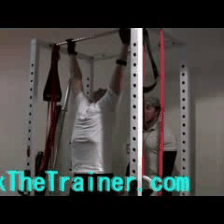

In [ ]:
import imageio
from tensorflow_docs.vis import embed

def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_featutes = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[1]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_featutes[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_featutes, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames

def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")

test_video = np.random.choice(test_df["path"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

In [ ]:
sequence_model.save(folder_root+'saved_model')

INFO:tensorflow:Assets written to: /content/drive/My Drive/video_classification_exercise/saved_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/video_classification_exercise/saved_model/assets
